In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from statistics import stdev, variance, mean
from fastai.tabular.all import *
from fastai.collab import CollabDataLoaders, collab_learner
from surprise import Reader, Dataset, accuracy, SVD
from surprise.model_selection import KFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## Exploratory Analysis

In [89]:
# Import of taining and test data
train = pd.read_csv("dados/train.csv")
test = pd. read_csv("dados/test.csv")
jokes = pd.read_csv("dados/jokes.csv")
print("Train " + str(train.shape))
print("Test " + str(test.shape))

Train (1092059, 4)
Test (537880, 3)


In [57]:
train

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [54]:
test

,id,user_id,joke_id
0,6194_11,6194,11
1,19356_3,19356,3
2,23426_79,23426,79
3,40030_3,40030,3
4,19806_115,19806,115


In [6]:
jokes

,joke_id,joke_text
0,1,"Q. What's O. J. Simpson's web address? A. Slash, slash, backslash, slash, slash, escape."
1,2,How many feminists does it take to screw in a light bulb? That's not funny.
2,3,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
3,4,"They asked the Japanese visitor if they have elections in his country. ""Every morning,"" he answers."
4,5,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?


In [6]:
train["joke_text"] = train.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])
test["joke_text"] = test.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


In [8]:
# Cheching uniqueness of data
train.select_dtypes(["int64", "float64", "object"]).nunique().sort_values().to_frame().T

,joke_id,Rating,user_id,id
0,139,641,40863,1092059


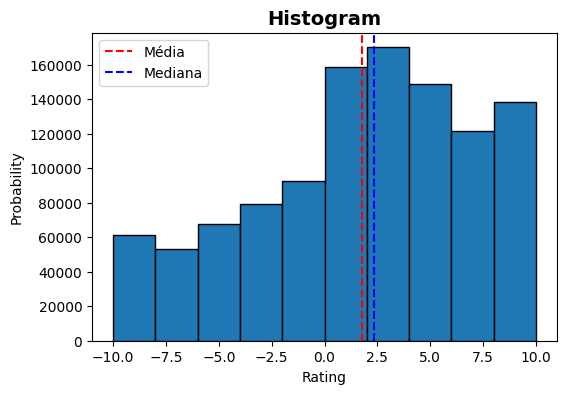

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(train.Rating, edgecolor="black")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.axvline(train.Rating.mean(), color="red", linestyle="--")
plt.axvline(train.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
plt.show()

In [ ]:
#
mean(train.Rating), stdev(train.Rating), variance(train.Rating)

## Model

In [117]:
reader = Reader(rating_scale=(-10., 10.))
data = Dataset.load_from_df(train[["user_id", "joke_id", "Rating"]], reader)

In [139]:
kf = KFold(n_splits=25, random_state=2)
model_svd = SVD(n_factors=500, n_epochs=150, lr_all=0.002, random_state=2)

In [140]:
mrmse = []
kfold = 0

for trainset, testset in kf.split(data):
    model_svd.fit(trainset)
    predic = model_svd.test(testset)
    result = round(accuracy.rmse(predic, verbose=False), 10)
    mrmse.append(result)
    kfold += 1
    print("Fold:", kfold, "RMSE:", result)
    
print("Média RMSE CV", mean(mrmse))

Fold: 1 RMSE: 4.022480292
Fold: 2 RMSE: 4.0434216556
Fold: 3 RMSE: 4.0112240336
Fold: 4 RMSE: 3.9990806759
Fold: 5 RMSE: 4.0209763788
Fold: 6 RMSE: 4.0063394407
Fold: 7 RMSE: 4.0171039151
Fold: 8 RMSE: 4.0106816866
Fold: 9 RMSE: 4.0317916075
Fold: 10 RMSE: 4.0514273617
Fold: 11 RMSE: 4.0170138544
Fold: 12 RMSE: 4.0271784629
Fold: 13 RMSE: 4.0132107717
Fold: 14 RMSE: 4.0092835669
Fold: 15 RMSE: 4.0175687638
Fold: 16 RMSE: 4.0271032279
Fold: 17 RMSE: 4.0240119199
Fold: 18 RMSE: 4.0095551655
Fold: 19 RMSE: 4.0250546031
Fold: 20 RMSE: 4.033257863
Fold: 21 RMSE: 4.0183233865
Fold: 22 RMSE: 4.0070728759
Fold: 23 RMSE: 4.0114345756
Fold: 24 RMSE: 4.0236949618
Fold: 25 RMSE: 4.0137682404
Média RMSE CV 4.019682371472


In [115]:
pred = []

for i in trange(test.shape[0]):
    pred.append((test.iloc[i, 0], model_svd.predict(test.iloc[i, 1], test.iloc[i, 2])[3]))

100%|██████████| 537880/537880 [01:24<00:00, 6347.77it/s]


## Bayesian optimization

In [127]:
def svd_bayesian(params):
    """ """
    model_svd = SVD(n_factors=params[0], n_epochs=params[1], lr_all=params[2], verbose=False, random_state=5)
    model_svd.fit(trainset)
    predic = model_svd.test(testset)
    result = round(accuracy.rmse(predic), 10)

    return result

In [69]:
kf = KFold(n_splits=5)
mrmse = []

def svd_bayesian_cv(params):
    """ """
    kfold = 0
    mrmse.clear()
    model_svd = SVD(n_factors=params[0], n_epochs=params[1], lr_all=params[2], verbose=False, random_state=5)
    for trainset, testset in kf.split(data):
        model_svd.fit(trainset)
        predic = model_svd.test(testset)
        result = round(accuracy.rmse(predic, verbose=False), 10)
        mrmse.append(result)
        kfold += 1
        print("Fold:", kfold, "RMSE:", result)
    
    print("Média RMSE CV", mean(mrmse), "\n")
    return min(mrmse)

In [ ]:
pbounds = [
    Integer(500, 550), #n_factors
    Integer(100, 150), #n_epochs
    Real(1e-3, 1e-1, "log-uniform") #lr_all
]

In [128]:
gpmin = gp_minimize(
    func=svd_bayesian, 
    dimensions=pbounds, 
    verbose=True, 
    n_initial_points=5, 
    n_calls=15,
    random_state=5
)

Iteration No: 1 started. Evaluating function at random point.
RMSE: 9.7813
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 214.9960
Function value obtained: 9.7813
Current minimum: 9.7813
Iteration No: 2 started. Evaluating function at random point.
RMSE: 4.0398
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 174.9775
Function value obtained: 4.0398
Current minimum: 4.0398
Iteration No: 3 started. Evaluating function at random point.
RMSE: 9.7813
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 216.1260
Function value obtained: 9.7813
Current minimum: 4.0398
Iteration No: 4 started. Evaluating function at random point.
RMSE: 4.0327
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 207.9965
Function value obtained: 4.0327
Current minimum: 4.0327
Iteration No: 5 started. Evaluating function at random point.
RMSE: 9.7813
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 195.8815
Function value o

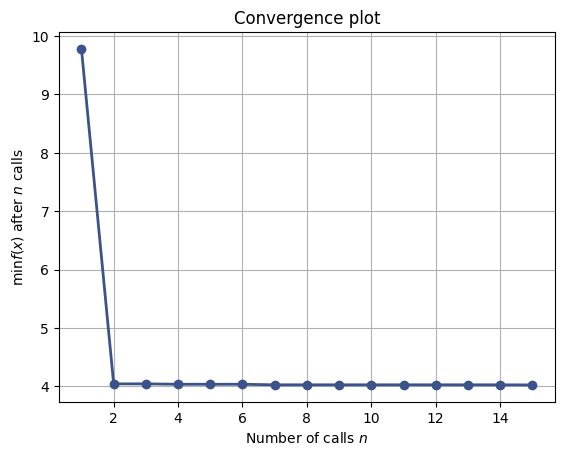

In [130]:
plot_convergence(gpmin)
plt.show()

In [132]:
gpmin.x

[500, 150, 0.002636920988115368]

In [137]:
gpmin.x_iters

[[517, 125, 0.020683069417915877],
 [540, 100, 0.0013976101758345874],
 [526, 126, 0.07747705649474365],
 [548, 114, 0.006635902876186745],
 [510, 111, 0.02384734880276758],
 [550, 150, 0.001],
 [547, 100, 0.0022210706238048055],
 [550, 100, 0.1],
 [550, 110, 0.005488912255690464],
 [550, 110, 0.005001839626485886],
 [548, 114, 0.005402193044089958],
 [544, 110, 0.0012799201923093116],
 [547, 115, 0.006152328244355581],
 [550, 100, 0.0032700860046309373],
 [500, 150, 0.002636920988115368]]

In [138]:
gpmin.func_vals

array([9.78125984, 4.03984622, 9.78125984, 4.03273915, 9.78125984,
       4.04285501, 4.02334236, 9.78125984, 4.02734727, 4.02573532,
       4.02696127, 4.0400498 , 4.02701123, 4.02377623, 4.02148195])

## Submission

In [116]:
# Submission surprise model
sub = pd.DataFrame(pred, columns = ["id", "Rating"])
sub.to_csv("submission.csv", index = False)

In [56]:
# Submission fastai model
test["Rating"] = preds
test.loc[:, ["id", "Rating"]].to_csv("submission.csv", index=False)
test.head()

,id,user_id,joke_id,Rating
0,6194_11,6194,11,1.157151
1,19356_3,19356,3,-0.514256
2,23426_79,23426,79,4.685508
3,40030_3,40030,3,-2.414566
4,19806_115,19806,115,6.191740
